In [1]:
import os
import numpy as np
import cloud_net_model
os.environ["CUDA_VISIBLE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
from skimage.transform import resize
from skimage import img_as_uint
from tensorflow.python.client import device_lib
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral, create_pairwise_gaussian
from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tf.Session(config=config)
KTF.set_session(session)
weights_path = '/home/wxw/.local/share/cloud-net/Cloud-Net/38-Cloud dataset/Cloud-Net_trained_on_38-Cloud_training_patches.h5'
model = cloud_net_model.model_arch(input_rows=384,
                                       input_cols=384,
                                       num_of_channels=4,
                                       num_of_classes=1)
model.load_weights(weights_path)

In [3]:
from skimage.io import imread,imsave,imshow
import numpy as np
import torch as nn

In [4]:
def split_and_resize_img(image,w,h):
    image=image/65536
    LU=image[0:512,0:512]
    RU=image[512:1024,0:512]
    LD=image[0:512,512:1024]
    RD=image[512:1024,512:1024]
    LU = resize (LU, (w, h), preserve_range=True, mode='symmetric')
    RU = resize (RU, (w, h), preserve_range=True, mode='symmetric')
    LD = resize (LD, (w, h), preserve_range=True, mode='symmetric')
    RD = resize (RD, (w, h), preserve_range=True, mode='symmetric')
    return LU,RU,LD,RD

In [5]:
def thres_adjust(pred,threshold):
    pred[pred>=threshold]=1
    pred[pred<threshold]=0
    pred=pred.astype(np.float32)
    return pred
    

In [6]:
img_root='/home/wxw/.local/share/cloud-net/datas'
imgs=os.listdir(img_root)
imgpaths=[]
for img in imgs:
    if 'tiff' in img:
        imgpaths.append(os.path.join(img_root,img))

In [7]:
img=imread(imgpaths[0])
img = resize (img, (384, 384), preserve_range=True, mode='symmetric')
img=np.array([img])
pred=model.predict(img)

In [19]:
img=imread(imgpaths[0])
LU,RU,LD,RD=split_and_resize_img(img,384,384)
pieces=np.array([LU,RU,LD,RD])
pieces.shape

(4, 384, 384, 4)

In [30]:
img=imread(imgpaths[0])
LU,RU,LD,RD=split_and_resize_img(img,384,384)
pieces=np.array([LU,RU,LD,RD])
preds=model.predict(pieces)
imgs=[]
for i in range(4):
    binary_pred=thres_adjust(preds[i],0.0000000000047)
    img=pieces[i][:,:,0:3]
    img=img*(1-binary_pred)
    imgs.append(img)

In [34]:
img=img*255
img=img.a
imsave(os.path.join('/home/wxw/.local/share/cloud-net/mixed_result','test.jpg'),imgs[0])

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


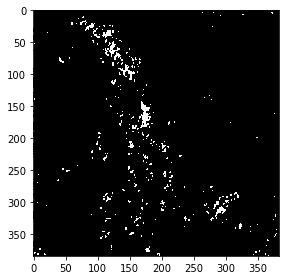

In [31]:
for imgpath in imgpaths:
    img=imread(imgpath)
    LU,RU,LD,RD=split_and_resize_img(img,384,384)
    pieces=np.array([LU,RU,LD,RD])
    preds=model.predict(pieces)
    for i in range(4):
        binary_pred=thres_adjust(preds[i],0.0000000000047)
        img=pieces[i]
        img=img*(1-binary_pred)
imshow(pred,cmap='gray')

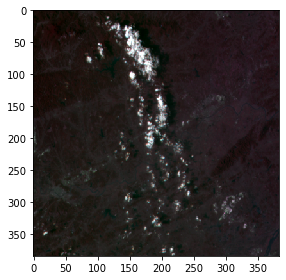

In [32]:
imshow(rgb)

In [33]:
pred=nn.tensor(pred)
pred=nn.sigmoid(pred)

In [34]:
d = dcrf.DenseCRF2D(384, 384, 2)  # 2 classes, width first then height
U = np.expand_dims(-np.log(pred), axis=0)  # [1, H, W], foreground
U_ = np.expand_dims(-np.log(1 - pred), axis=0)  # [1, H, W], background
unary = np.concatenate((U_, U), axis=0)
unary = unary.reshape((2, -1))  # flatten, [2, HW], define unary
d.setUnaryEnergy(unary)   # 得到一元势（负对数概率）

In [36]:
d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                              normalization=dcrf.NORMALIZE_SYMMETRIC)
#增加了与颜色无关的术语，只是位置-----会惩罚空间上孤立的小块分割,即强制执行空间上更一致的分割
d.addPairwiseBilateral(sxy=(80, 80), srgb=(13, 13, 13), rgbim=rgb,compat=10,
                               kernel=dcrf.DIAG_KERNEL,
                               normalization=dcrf.NORMALIZE_SYMMETRIC)
#增加了颜色相关术语，即特征是(x,y,r,g,b)-----使用局部颜色特征来细化它们

In [37]:
Q = d.inference(5)  # inference 5 times
pred_raw_dcrf = np.argmax(Q, axis=0).reshape((384, 384)).astype(np.float32)

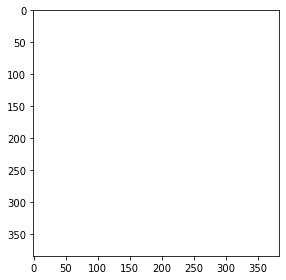

In [38]:
imshow(pred_raw_dcrf,cmap='gray')

/home/wxw/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


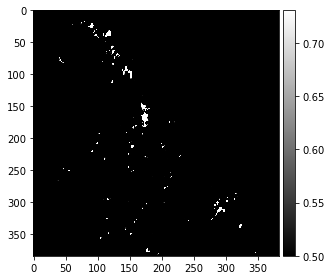

In [50]:
imshow(pred.numpy(),cmap='gray')

In [115]:
img_red=img[:,:,0]
img_green=img[:,:,1]
img_blue=img[:,:,2]
nir=img[:,:,3]
image = np.stack((img_red, img_green, img_blue, nir), axis=-1)
image=image[512:1024,0:512]
image = resize (image, (384, 384), preserve_range=True, mode='symmetric')
image=image/65536
image=np.array([image])
image.shape

(1, 384, 384, 4)

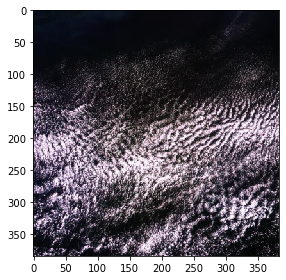

In [116]:
imshow(image[0][:,:,0:3])

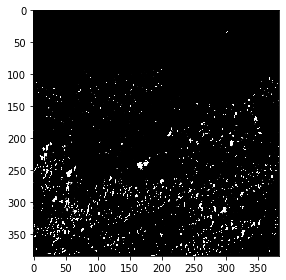

In [117]:
result=model.predict(image)
imshow(result[0],cmap='gray')

In [53]:
imsave('/home/wxw/.local/share/cloud-net/datas/area2-0_pred.tiff',result[0])

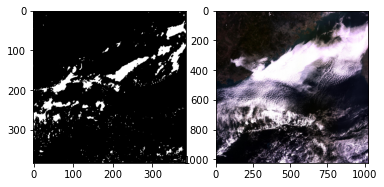

In [114]:
pred=imread('/home/wxw/.local/share/cloud-net/predictions/area2-1_pred.tiff')
rgb=imread('/home/wxw/.local/share/cloud-net/datas/area2-1.tiff')
rgb=rgb[:,:,0:3]/65535
plt.subplot(1,2,1)
plt.imshow(pred,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(rgb,cmap='gray')
plt.show()

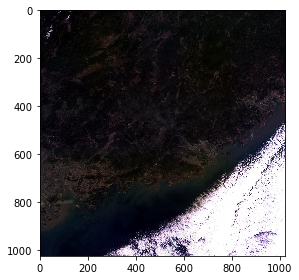

In [105]:
rgb=imread('/home/wxw/.local/share/cloud-net/datas/area3-0.tiff')
rgb=rgb[:,:,0:3]/65535
imshow(rgb)

/home/wxw/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


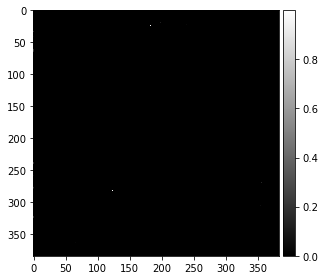

In [61]:
img=imread('/home/wxw/.local/share/cloud-net/datas/area7-0.tiff')
img_red=img[:,:,0]
img_green=img[:,:,1]
img_blue=img[:,:,2]
nir=img[:,:,3]
image = np.stack((img_red, img_green, img_blue, nir), axis=-1)
image = resize (image, (384, 384), preserve_range=True, mode='symmetric')
image=image/65536
image=np.array([image])
result=model.predict(image)
imshow(result[0],cmap='gray')

In [35]:
img_red=img[:,:,0]
img_green=img[:,:,1]
img_blue=img[:,:,2]
img_red=img_as_uint(img_red)
img_green=img_as_uint(img_green)
img_blue=img_as_uint(img_blue)
nir=img_as_uint(nir)
image = np.stack((img_red, img_green, img_blue, nir), axis=-1)
image = resize (image, ( 384, 384), preserve_range=True, mode='symmetric')

In [36]:
image=image/65536
image=np.array([image])
image.shape

(1, 384, 384, 4)

In [37]:
result=model.predict(image)

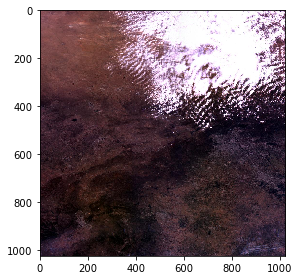

In [66]:
img=imread('/home/wxw/.local/share/cloud-net/datas/area7-0.tiff')
imshow(img[:,:,0:3]/65535,cmap='gray')

/home/wxw/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


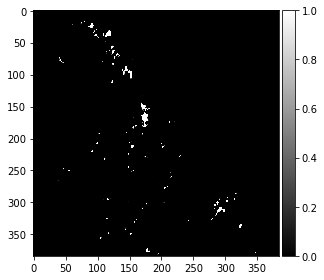

In [64]:
pred = imread('/home/wxw/.local/share/cloud-net/18pred.TIF')
imshow(pred,cmap='gray')

In [70]:
pred=np.round(pred)
pred=pred.astype(np.int32)

In [71]:
np.sum(pred==1)

868

In [72]:
U = unary_from_labels(pred, 2, gt_prob=0.2, zero_unsure=None)

In [68]:
pred.dtype

dtype('float32')

In [ ]:
d = dcrf.DenseCRF2D(img.shape[1], img.shape[0], 2)
U = unary_from_labels(pred, 2, gt_prob=0.2, zero_unsure=None)
d.setUnaryEnergy(U)
d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                              normalization=dcrf.NORMALIZE_SYMMETRIC)
d.addPairwiseBilateral(sxy=(80, 80), srgb=(13, 13, 13), rgbim=img,compat=10,
                               kernel=dcrf.DIAG_KERNEL,
                               normalization=dcrf.NORMALIZE_SYMMETRIC)
